## Imports

In [1]:
### Data Utils
import numpy as np
import pandas as pd
from tensorflow.keras.utils import get_file
from keras.utils import np_utils

In [2]:
## Clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score, silhouette_samples, matthews_corrcoef, f1_score
from sklearn.utils import shuffle

In [3]:
## Classification
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

from tensorflow.keras import layers, activations
from tensorflow.keras.utils import to_categorical

In [4]:
### Plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

## Load Data

In [5]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls"
path = get_file(URL.split('/')[-1], URL)
excel_file = pd.ExcelFile(path)
data = pd.read_excel(excel_file, 1)

1744896/1743872 [==============================] - 1s 1us/step


## Exploratory Data Analysis

In [6]:
data.isnull().any().sum()

46

In [7]:
cols_to_drop = ['Unnamed: 0','Unnamed: 1','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 31', 'Unnamed: 42', 'Unnamed: 44']
data = data.drop(cols_to_drop, axis=1)

In [8]:
col_names = data.loc[0, :]
data = data[1:-3]
data.columns = col_names

In [ ]:
data.head()

In [9]:
int_cols = ['Min', 'Max', 'Width', 'Nmax', 'Nzeros', 'Tendency', 'CLASS', 'NSP']
for col in data.columns:
  if col in int_cols:
    data[col] = data[col].astype(int)
  else:
    data[col] = data[col].astype(float)

In [ ]:
data.dtypes

In [10]:
X = data.loc[:, 'LB':'Tendency']
y_nsp = data.NSP
y_class = data.CLASS

### Class Distributions

In [ ]:
gs1 = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.05)

nsp_labels = ['Normal', 'Suspect', 'Pathologic']
class_labels = ['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']

titles = ['NSP', 'CLASS']
labels = [nsp_labels, class_labels]

total_count = data.shape[0]
nsp_count = data.NSP.value_counts().sort_values(ascending=False)
class_count = data.CLASS.value_counts().sort_values(ascending=False)
value_counts = [nsp_count, class_count]

plt.figure(figsize=(15, 7))
for idx, value_count in enumerate(value_counts):
  label_elements = len(labels[idx])
  plt.subplot(gs1[idx])
  value_count.plot(kind='bar', rot=0)
  
  for x, y in enumerate(value_count):
    text = str(round((y / total_count) * 100, 2)) + '%'
    plt.annotate(text, (x, y), textcoords="offset points", xytext=(0,6), ha='center')
  plt.title(f'{titles[idx]} Distribution')
  plt.xticks(range(label_elements), labels[idx])
  plt.xlabel("Class")
  plt.ylabel("Frequency")
  plt.grid(axis='y')
  plt.savefig("Distributions.png", dpi=300)

### Feature Density Analysis

Check the Univariate Distributions and detect possible outliers

In [ ]:
features_to_explore = ['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV']
for feature in features_to_explore:
  fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(15, 4))
  fig.suptitle(feature, fontsize=20)

  ### distribution
  ax[0].title.set_text('Distribution')
  variable = X[feature].fillna(X[feature].mean())
  breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
  variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]
  sns.histplot(variable, kde=True, ax=ax[0], alpha=0.7)
  des = X[feature].describe()
  ax[0].axvline(des['25%'], ls='--', color='orange')
  ax[0].axvline(des['mean'], ls='--', color='orange')
  ax[0].axvline(des['75%'], ls='--', color='orange')
  ax[0].grid(True)
  des = round(des, 2).apply(lambda x: str(x))
  box = '\n'.join(('min: ' + des['min'], '25%: ' + des['25%'], 'mean: ' + des['mean'], '75%: ' + des['75%'], 'max: ' + des['max']))
  ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha='right', bbox=dict(boxstyle='round', facecolor='white', alpha=1))

  ### boxplot 
  ax[1].title.set_text('Boxplot (Outliers)')
  tmp = pd.DataFrame(X[feature])
  # tmp[x] = np.log(tmp[x])
  tmp.boxplot(column=feature, ax=ax[1])
  plt.savefig(f'Univariate_{feature}.png', dpi=300)
  plt.show()

Look into the bivariate distribution to understand if *LB* has predictive power to predict *NSP*.

In [ ]:
cat, num = "NSP", "LB"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=(20, 6))
fig.suptitle(f'{num}  vs  {cat}', fontsize=20)
            
ax[0].title.set_text('Density')
for i in y_nsp.unique():
    sns.kdeplot(data[data[cat] == i][num], label=i, ax=ax[0])
ax[0].grid(True)

### stacked
ax[1].title.set_text('Bins')
breaks = np.quantile(X[num], q=np.linspace(0,1,11))
tmp = data.groupby([cat, pd.cut(X[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[data[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)

### boxplot   
ax[2].title.set_text('Outliers')
sns.boxplot(x=cat, y=num, data=data, ax=ax[2])
ax[2].grid(True)
plt.show()
plt.savefig("Bivariate_LB.png", dpi=300)

## Dimensionality Reduction

### Correlation Heatmap

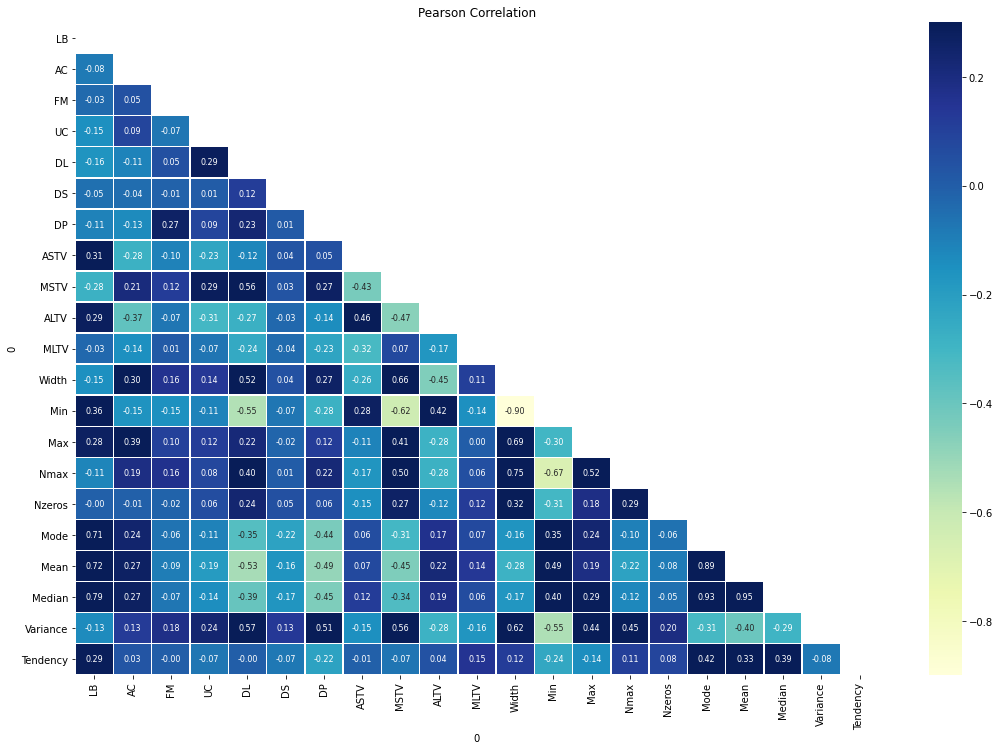

In [17]:
# Compute the correlation matrix
correlation_matrix = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(18, 12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='YlGnBu', annot=True, vmax=0.3, annot_kws={"size": 8}, linewidths=0.5, fmt='.2f')

plt.title('Pearson Correlation')
plt.savefig("Correlation.png", dpi=300)

In [ ]:
abs_corr = X.corr().abs()
abs_corr[abs_corr == 1] = 0
corr_cols = abs_corr.unstack().sort_values(ascending=False).drop_duplicates()
corr_df = pd.DataFrame(corr_cols[corr_cols > 0.8])
corr_df

### Feature Selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_nsp, test_size=0.3, random_state=0, stratify=y_nsp, shuffle=True)
classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
std = StandardScaler()

In [ ]:
print(pd.Series(y_nsp).value_counts(normalize=True))
print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_test).value_counts(normalize=True))

In [ ]:
x_values = X_train.values
y_values = y_train.values

feature_names = X_train.columns.to_list()
classifier.fit(x_values, y_values)
importances = classifier.feature_importances_
importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
importances['cumsum'] =  importances['IMPORTANCE'].cumsum(axis=0)
importances = importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(18, 6))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('Variables')
importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")

ax[1].title.set_text('Cumulative Importance')
importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1]).grid(axis='both')
ax[1].set(xlabel="", xticks=np.arange(len(importances)), xticklabels=importances.index)
plt.xticks(rotation=70)
plt.savefig("Feature_Importance.png", dpi=300)
plt.show()

In [ ]:
importances

In [ ]:
redundant_features = ['DS', 'Mode', 'Median', 'Width']
X_train = X_train.drop(redundant_features, axis=1)
X_test = X_test.drop(redundant_features, axis=1)

In [ ]:
X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)

### PCA

In [ ]:
pca = PCA().fit(X_train_scaled)
plt.figure(figsize=(10, 6)) 

xi = np.arange(1, X_train_scaled.shape[1] + 1, step = 1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='dashdot', color='b')

plt.xlabel('Number of Components')
plt.xticks(xi)
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-', alpha=0.5)
plt.text(13.5, 0.9, '95% cut-off threshold', color='r', fontsize = 12)
plt.grid(axis='x')

plt.savefig("PCA-Components-to-Variance-ratio.png", dpi=300)
plt.show()

In [ ]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
classifier.fit(X_train_pca, y_train)
y_pred_pca = classifier.predict(X_test_pca)

print(classification_report(y_test, y_pred_pca, zero_division=0, target_names=nsp_labels))

### LDA

In [ ]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

In [ ]:
classifier.fit(X_train_lda, y_train)
y_pred_lda = classifier.predict(X_test_lda)

print(classification_report(y_test, y_pred_lda, zero_division=0, target_names=nsp_labels))

### Comparison (PCA vs LDA)

In [ ]:
preds = [y_pred_pca, y_pred_lda]
titles = ['PCA (n_components = ' , 'LDA (n_components = ']
figure, axes = plt.subplots(1, len(preds), figsize=(15, 10))
components = [pca.n_components_, lda.n_components]
for current_index, pred in enumerate(preds):
  conf_matrix = confusion_matrix(y_true = y_test, y_pred = pred)
  axes[current_index].matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
  
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          axes[current_index].text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')
  
  axes[current_index].set_xlabel('Predictions', fontsize=15)
  axes[current_index].set_ylabel('Actuals', fontsize=15)
  axes[current_index].set_title(f'{titles[current_index]} {components[current_index]})', fontsize=15)
  axes[current_index].text(0.5, 2.8, f'\nPrediction Success: {accuracy_score(y_test, pred):.2%}')
  
  plt.savefig("Confusion Matrices.png", dpi=300)

## Clustering

### KMeans

In [ ]:
range_n_clusters = [3, 4, 5, 10]
fig, ax = plt.subplots(4, 1, figsize=(7, 30))
ax[0].set_title("The silhouette plot for the various clusters.")

for idx, n_clusters in enumerate(range_n_clusters):

  # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
  ax[idx].set_ylim([0, len(X_train_lda) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, random_state=0)
  cluster_labels = clusterer.fit_predict(X_train_lda)

  silhouette_avg = silhouette_score(X_train_lda, cluster_labels)
  sample_silhouette_values = silhouette_samples(X_train_lda, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[idx].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)    
    ax[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[idx].set_xlabel(f'Average Silhouette Score is : {silhouette_avg:.2f}')
  ax[idx].set_ylabel("Cluster label")
  ax[idx].axvline(x=silhouette_avg, color="red", linestyle="--")
  ax[idx].set_yticks([])  # Clear the y-axis labels
  ax[idx].set_xticks(np.arange(-0.3, 1.2, 0.2))

plt.savefig('Cluster Sihlouette Plot.png', dpi=300)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train_lda)

### DBSCAN
1.   HyperParameter Tuning
2.   Cluster

In [ ]:
distance = NearestNeighbors(n_neighbors=2).fit(X_train_lda)
dist, idx = distance.kneighbors(X_train_lda)

sorting_dist = np.sort(dist, axis=0)
sorted_dist = sorting_dist[:,1]
plt.figure(figsize=(10, 6))
plt.plot(sorted_dist)

plt.title('Epsilon Optimization')
plt.xlabel('Distance')
plt.ylabel('Epsilon')
plt.yticks(np.arange(0, 1.7, 0.2))
plt.grid()

plt.savefig(f'Eps Optimization.png', dpi=300)
plt.show()

The optimal value for epsilon will be found at the point of maximum curvature 

In [ ]:
dbscan = DBSCAN(eps=0.4, min_samples=10).fit(X_train_lda)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

dbscan_labels = dbscan.labels_
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

### Hierarchical

In [ ]:
plt.figure(figsize=(18, 8))
linkage_matrix = linkage(X_train_lda, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=30)
plt.title('Hierarchical Clustering Dendrogram', size=16)
plt.xlabel('Sample Index')
plt.ylabel('Distance ')
plt.axhline(y=35, color='black', linestyle='--')
plt.savefig("Dendrogram.png", dpi=300)

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical.fit(X_train_lda)

labels_unique = np.unique(hierarchical.labels_)
ms_clusters = len(labels_unique)

### Mean Shift

In [ ]:
bandwidth = estimate_bandwidth(X_train_lda, quantile=0.25, n_samples=150)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_train_lda)

labels_unique = np.unique(ms.labels_)
ms_clusters = len(labels_unique)

### Sihlouette Analysis and Scatter Plots

In [ ]:
titles = ['KMeans Clustering', 'DBSCAN Clustering', 'Agglomerative Clustering', 'Mean Shift Clustering']
cluster_labels = [kmeans.labels_, dbscan.labels_, hierarchical.labels_, ms.labels_]
n_clusters = [3, dbscan_clusters, hierarchical.n_clusters_, ms_clusters]

for idx, title in enumerate(titles):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(20, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(X_train_lda) + (n_clusters[idx] + 1) * 10])
  
  silhouette_avg = silhouette_score(X_train_lda, cluster_labels[idx])
  sample_silhouette_values = silhouette_samples(X_train_lda, cluster_labels[idx])

  y_lower = 10
  for i in range(n_clusters[idx]):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels[idx] == i]

    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters[idx])
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i != 0:
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10 

  ax1.set_title(f'The silhouette plot for {title} (Score: {silhouette_avg:.2f})')
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks(np.arange(-0.5, 1.2, 0.2))

  scatter = ax2.scatter(X_train_lda[:,0], X_train_lda[:,1], c = cluster_labels[idx])
  ax2.set_title(title)
  legend = ax2.legend(*scatter.legend_elements(), title="NSP Classes")
  ax2.add_artist(legend)

  plt.suptitle(f'Silhouette analysis for {title} with {n_clusters[idx]} clusters',fontsize=16, fontweight='bold')
  plt.savefig(f'{title}.png', dpi=300)

plt.show()

## Classification

In [ ]:
data.head()

In [ ]:
data.drop(class_labels, axis=1, inplace=True)

### Normalize Data

In [ ]:
num_cols = data.columns

min_max = MinMaxScaler()
scaled = min_max.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

In [ ]:
scaled = shuffle(scaled)
y_class = scaled.CLASS
le = LabelEncoder().fit(y_class)
y_bool = le.transform(y_class)
y = to_categorical(y_bool)

In [ ]:
length = X.shape[0]

train_size = int(length * 0.6)
val_size = int(length * 0.1)

x_train = scaled[:train_size]
y_train = y[:train_size]
y_train_bool = y_bool[:train_size]

x_val = scaled[train_size:train_size + val_size + 1]
y_val = y[train_size:train_size + val_size + 1]
y_val_bool = y_bool[train_size:train_size + val_size + 1]

x_test = scaled[train_size + val_size + 1:]
y_test = y[train_size + val_size + 1:]
y_test_bool = y_bool[train_size + val_size + 1:]

print(f'Train size: {len(x_train)}, {len(y_train)}')
print(f'Val size: {len(x_val)}, {len(y_val)}')
print(f'Test size: {len(x_test)}, {len(y_test)}')

Train size: 1275, 1275
Val size: 213, 213
Test size: 638, 638


In [ ]:
scaled.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
867,0.666667,0.060652,0.000000,0.391813,0.000000,0.0,0.000000,0.413333,0.073529,0.406593,0.142012,0.141243,0.733945,0.310345,0.166667,0.0,0.685039,0.669725,0.651376,0.000000,0.5,0.000000,0.0
1158,0.388889,0.443223,0.000000,0.490842,0.158730,0.0,0.228327,0.133333,0.220588,0.000000,0.000000,0.711864,0.018349,0.508621,0.444444,0.0,0.629921,0.577982,0.596330,0.234201,1.0,0.555556,0.0
936,0.370370,0.000000,0.000000,0.522757,0.000000,0.0,0.000000,0.280000,0.117647,0.000000,0.270217,0.163842,0.541284,0.163793,0.055556,0.0,0.559055,0.532110,0.513761,0.007435,1.0,0.000000,0.0
82,0.722222,0.000000,0.015004,0.161058,0.000000,0.0,0.000000,0.386667,0.147059,0.000000,0.311637,0.751412,0.091743,0.637931,0.444444,0.1,0.669291,0.688073,0.660550,0.022305,0.5,0.000000,0.0
1683,0.074074,0.179747,0.003606,0.464471,0.450607,0.0,0.324090,0.746667,0.411765,0.000000,0.000000,0.734463,0.091743,0.612069,0.333333,0.0,0.244094,0.100917,0.155963,0.167286,0.0,0.777778,1.0


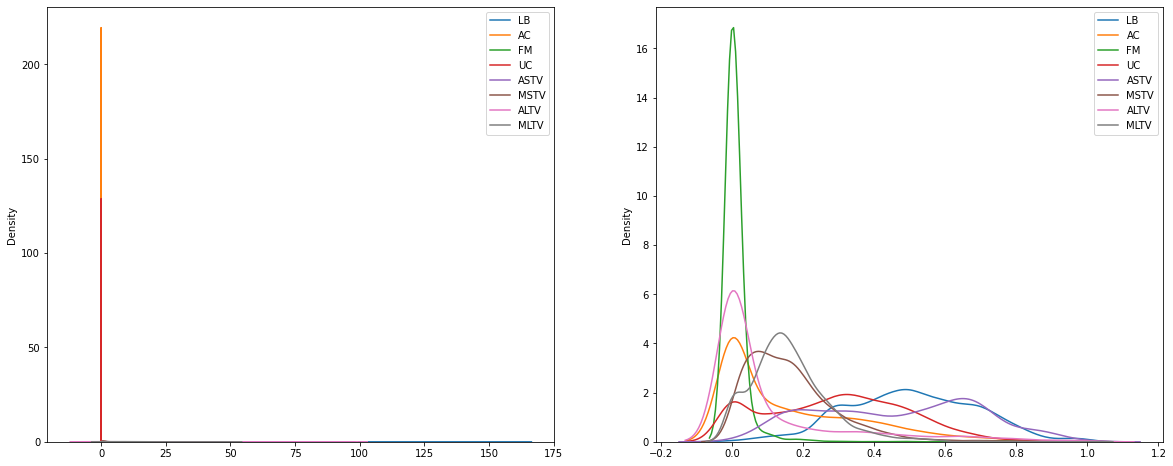

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
for feature in features_to_explore:
  sns.kdeplot(x=data[feature], alpha=0.7, label=feature, ax=ax[0])
  sns.kdeplot(x=scaled[feature], alpha=0.7, label=feature, ax=ax[1])
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.savefig('Before-After Normalization.png', dpi=300)

### Building the model

In [ ]:
INPUT_DIM = scaled.shape[1]
LEARNING_RATE = 0.001
OUTPUT_CLASSES = y.shape[1]

EPOCHS = 30
BATCH_SIZE = 1
def create_model(input_dim, learn_rate, output):
  # Create Model
  model = Sequential(
      [
      layers.Dense(60, input_dim=input_dim, activation=activations.relu),
      layers.Dense(30, activation=activations.relu),
      layers.Dense(30, activation=activations.relu),
      layers.Dropout(0.1),
      layers.Dense(output, activation=activations.softmax)
      ]
  )

  # Compile
  adam = Adam(learning_rate=learn_rate)
  model.compile(loss=CategoricalCrossentropy(), optimizer=adam, metrics=[CategoricalAccuracy()])
  return model

model = create_model(INPUT_DIM, LEARNING_RATE, OUTPUT_CLASSES)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/30
1275/1275 [==============================] - 2s 1ms/step - loss: 1.5228 - categorical_accuracy: 0.4770 - val_loss: 0.4411 - val_categorical_accuracy: 0.9343
Epoch 2/30
1275/1275 [==============================] - 1s 1ms/step - loss: 0.4661 - categorical_accuracy: 0.8559 - val_loss: 0.1753 - val_categorical_accuracy: 0.9577
Epoch 3/30
1275/1275 [==============================] - 1s 1ms/step - loss: 0.2542 - categorical_accuracy: 0.9227 - val_loss: 0.0821 - val_categorical_accuracy: 0.9906
Epoch 4/30
1275/1275 [==============================] - 1s 1ms/step - loss: 0.1656 - categorical_accuracy: 0.9418 - val_loss: 0.1731 - val_categorical_accuracy: 0.9624
Epoch 5/30
1275/1275 [==============================] - 1s 1ms/step - loss: 0.1639 - categorical_accuracy: 0.9525 - val_loss: 0.0358 - val_categorical_accuracy: 0.9953
Epoch 6/30
1275/1275 [==============================] - 1s 1ms/step - loss: 0.0999 - categorical_accuracy: 0.9700 - val_loss: 0.0267 - val_categorical_accuracy:

### Plotting Accuracy and Loss 

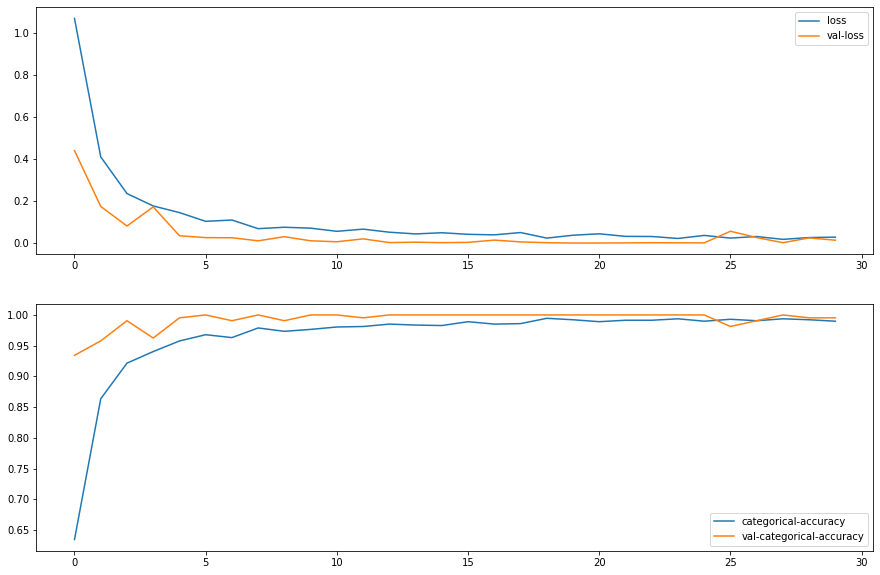

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.legend()
# plt.savefig('Train-Val Loss.png', dpi=300)

plt.subplot(2, 1, 2)
plt.plot(history.history['categorical_accuracy'], label='categorical-accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val-categorical-accuracy')
plt.legend()
# plt.savefig('Train-Val Accuracy.png', dpi=300)
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
print(f'Validation Loss - Accuracy: {val_loss:.3f} - {val_acc:.2%}')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss - Accuracy: {test_loss:.3f} - {test_acc:.2%}')

Validation Loss - Accuracy: 0.014 - 99.53%
Test Loss - Accuracy: 0.038 - 99.37%


In [ ]:
valPredict = model.predict(x_val, batch_size=BATCH_SIZE)
valPredict = np.argmax(valPredict, axis=1)
print(f'F1-Score for validation set: {f1_score(y_true=y_val_bool, y_pred=valPredict, average="weighted"):.3f}')

testPredict = model.predict(x_test, batch_size=BATCH_SIZE)
testPredict = np.argmax(testPredict, axis=1)
print(f'F1-Score for test set: {f1_score(y_true=y_test_bool, y_pred=testPredict, average="weighted"):.3f}')

F1-Score for validation set: 0.995
F1-Score for test set: 0.994


In [ ]:
print(f'\t\tClassification Report (Validation Set)\n{classification_report(y_true=y_val_bool, y_pred=valPredict, target_names=class_labels)}')

		Classification Report (Validation Set)
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        35
           B       1.00      1.00      1.00        72
           C       1.00      1.00      1.00         5
           D       1.00      1.00      1.00         7
           E       1.00      1.00      1.00         9
          AD       1.00      1.00      1.00        25
          DE       1.00      1.00      1.00        21
          LD       1.00      1.00      1.00        16
          FS       1.00      0.83      0.91         6
        SUSP       0.94      1.00      0.97        17

    accuracy                           1.00       213
   macro avg       0.99      0.98      0.99       213
weighted avg       1.00      1.00      1.00       213



In [ ]:
print(f'\t\tClassification Report (Test Set)\n{classification_report(y_true=y_test_bool, y_pred=testPredict, target_names=class_labels)}')

		Classification Report (Test Set)
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       121
           B       1.00      1.00      1.00       172
           C       1.00      1.00      1.00        22
           D       1.00      1.00      1.00        26
           E       1.00      1.00      1.00        27
          AD       1.00      1.00      1.00        90
          DE       0.98      1.00      0.99        84
          LD       1.00      1.00      1.00        24
          FS       1.00      0.90      0.95        20
        SUSP       0.96      0.96      0.96        52

    accuracy                           0.99       638
   macro avg       0.99      0.99      0.99       638
weighted avg       0.99      0.99      0.99       638

